# Mode d'emploi sur l'utilisation de la librairie

#### Import des sous modules de la librairie

In [1]:
from tools import RateCurveType, InterpolationType, CalendarConvention
from kernel.market_data.market import Market

#### Informations renseignées par l'utilisateur (sur l'interface)

In [2]:
security = "Apple"
rate_curve_type = RateCurveType.RF_US_TREASURY
interpolation_type = InterpolationType.SVENSSON
# volatility_surface_type = VolatilitySurfaceType.SVI
calendar = CalendarConvention.ACT_360

#### Initialisation du marché

In [3]:
market = Market(underlying_name=security,
                rate_curve_type=RateCurveType.RF_US_TREASURY,
                interpolation_type=InterpolationType.SVENSSON,
                # volatility_surface_type=VolatilitySurfaceType.SVI,
                calendar_convention=CalendarConvention.ACT_360)

#### Exemples d'utilisation des informations stockées dans le marché

In [7]:
print(f"Taux 1.2Y interpolé: {round(market.get_rate(1.2),2)}%")
print(f"Volatilité K=220, T=24 jours interpolée: {round(market.get_volatility(220, 24),2)}%")

Taux 1.2Y interpolé: 1.91%
Volatilité K=220, T=24 jours interpolée: 0.36%


#### Visualisation de l'interpolation de la courbe de taux

c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve\interpolators\svensson_interpolator.py:46: RuntimeWarning: invalid value encountered in scalar divide
  term1 = beta1 * (1 - np.exp(-t / tau1)) / (t / tau1)
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve\interpolators\svensson_interpolator.py:47: RuntimeWarning: invalid value encountered in scalar divide
  term2 = beta2 * ((1 - np.exp(-t / tau1)) / (t / tau1) - np.exp(-t / tau1))
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve\interpolators\svensson_interpolator.py:48: RuntimeWarning: invalid value encountered in scalar divide
  term3 = beta3 * ((1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2))


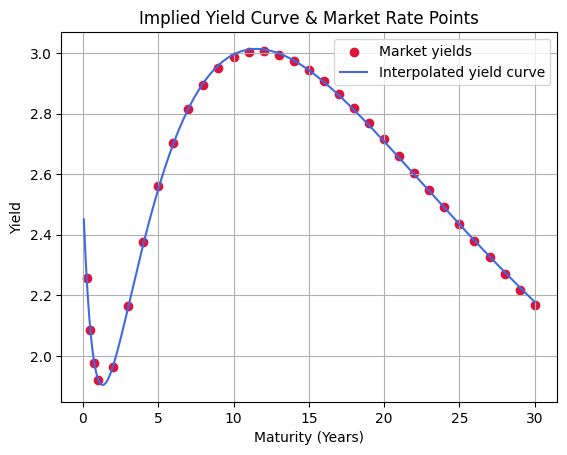

In [8]:
market.rate_curve.display_curve()

#### Visualisation de la surface de volatilité

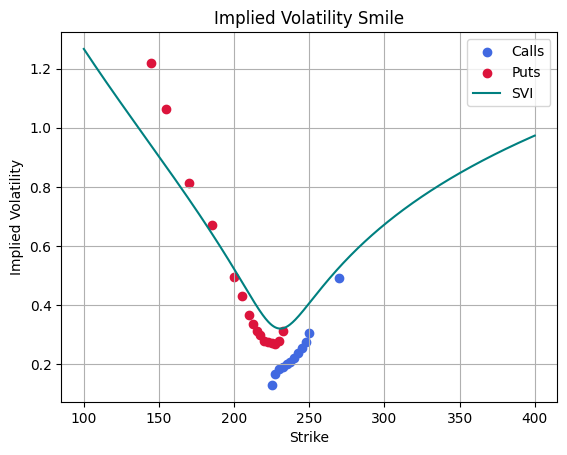

In [9]:
market.volatility_surface.display_smile(24)

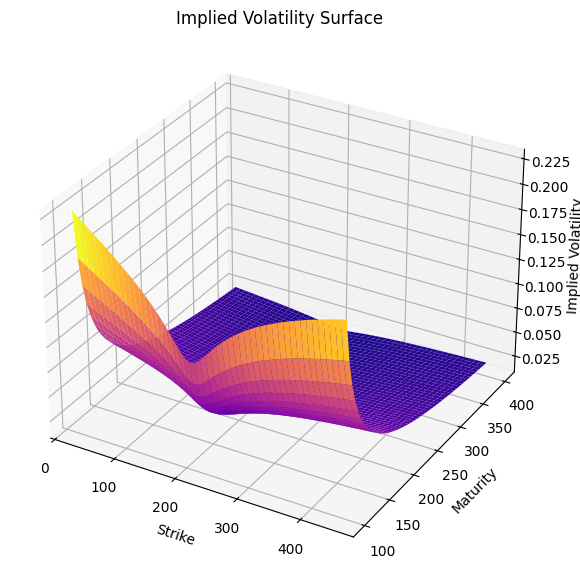

In [10]:
market.volatility_surface.display_surface()